In [2]:
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

**Daugman's filter function**

In [3]:
def daugman(center, start_r, gray_img):
    """return maximal intense radius for given center
    center -- tuple(x, y)
    start_r -- int
    gray_img -- grayscale picture as np.array(), it should be square
    """
    # get separate coordinates
    x, y = center
    # get img dimensions
    h, w = gray_img.shape
    # for calculation convinience
    img_shape = np.array([h, w])
    c = np.array(center)
    # define some other vars
    tmp = []
    mask = np.zeros_like(gray)

    # for every radius in range
    # we are presuming that iris will be no bigger than 1/3 of picture
    for r in range(start_r, int(h/3)):
        # draw circle on mask
        cv2.circle(mask, center, r, 255, 1)
        # get pixel from original image
        radii = gray_img & mask  
        # normalize
        tmp.append(radii[radii > 0].sum()/(2*3.1415*r))
        # refresh mask
        mask.fill(0)

    # calculate delta of radius intensitiveness
    tmp = np.array(tmp)
    tmp = tmp[1:] - tmp[:-1]
    # aply gaussian filter
    tmp = abs(cv2.GaussianBlur(tmp[:-1], (1, 5), 0))
    # get maximum value
    idx = np.argmax(tmp)
    # return value, center coords, radius
    return tmp[idx], [center, idx + start_r]

**Find raduis and center coordinates function**

In [4]:
def find_iris(gray, start_r):
    """Apply daugman() on every pixel in calculated image slice
        gray -- graysacale img as np.array()
        start_r -- initial radius as int
    Selection of image slice guarantees that every
    radius will be drawn in iage borders, so we need to check it (speed up)

    To speed up the whole process we need to pregenerate all centers for detection
    """
    _, s = gray.shape
    # reduce step for better accuracy
    # 's/3' is the maximum radius of a daugman() search
    a = range(0 + int(s/3), s - int(s/3), 3)
    all_points = list(itertools.product(a, a))

    values = []
    coords = []

    for p in all_points:
        tmp = daugman(p, start_r, gray)
        if tmp is not None:
            val, circle = tmp
            values.append(val)
            coords.append(circle)
    return coords[np.argmax(values)]

In [5]:
def showImage(image, title): 
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])

def showImageBGR(image, title):
    showImage(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), title)

**Resize image and apply ROI**

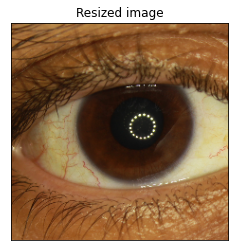

In [7]:
img=cv2.imread('/content/44.JPG')
M, N, c = img.shape

im_rgb_foc = img[int(0.3*M):int(0.7*M), int(0.5*M):int(0.9*M)]
w,h,c=im_rgb_foc.shape

im_rgb_foc = cv2.resize(im_rgb_foc, (int(w/6),int(w/6)))
showImageBGR(im_rgb_foc, "Resized image")


**Applying Daugman's filter**

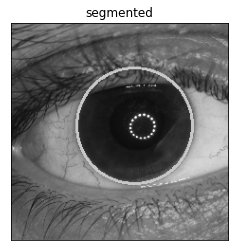

In [9]:
gray = cv2.cvtColor(im_rgb_foc, cv2.COLOR_BGR2GRAY)
outer = find_iris(gray,45)
inner = find_iris(gray,20)

color = (200,10,200)
thickness = 2
image = cv2.circle(gray, outer[0], outer[1], color, thickness)
image = cv2.circle(gray, inner[0], inner[1], color, thickness)
showImageBGR(image, "segmented")


**Problem:**
- The difference between Iris and pupil Intensities is very small and the Daugman’s operator searches for the circular path where there is maximum change in pixel values, so we need to increase the difference between iris and eye pupil intensities.

**Solution:**
We can do that by converting RGB image to HSV then to Gray scale as shown below.

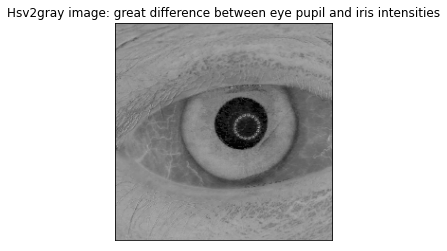

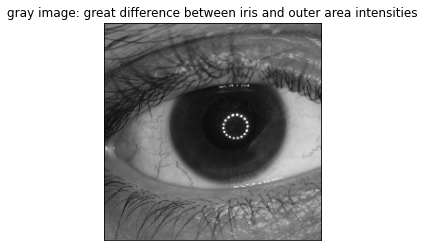

In [14]:
imgHsv=cv2.cvtColor(im_rgb_foc,cv2.COLOR_BGR2HSV)
Hsv2gray = cv2.cvtColor(imgHsv, cv2.COLOR_BGR2GRAY)
Gray = cv2.cvtColor(im_rgb_foc, cv2.COLOR_BGR2GRAY)

showImageBGR(Hsv2gray, "Hsv2gray image: great difference between eye pupil and iris intensities")
showImageBGR(Gray, "gray image: great difference between iris and outer area intensities")

**Now we can detect the outer circle from Gray image and the inner circle from Hsv2Gray image**

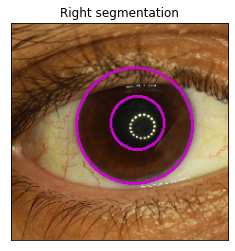

In [15]:
outer = find_iris(Gray,45)
inner = find_iris(Hsv2gray,20)

color = (200,10,200)
thickness = 2
seg_img = cv2.circle(im_rgb_foc, outer[0], outer[1], color, thickness)
seg_img = cv2.circle(im_rgb_foc, inner[0], inner[1], color, thickness)
showImageBGR(seg_img, "Right segmentation")